In [7]:
# 🟩 STEP 4: Set up and Extract Dataset Locally (VS Code)
import os
import zipfile

# --- Configuration ---
# 1. The name of your dataset zip file.
ZIP_FILE_PATH = 'dataset.zip'
# 2. The directory where the dataset contents (train, test folders) will be extracted.
# We create a new folder named 'content' in the same directory as the notebook.
EXTRACT_PATH = './content/'

# The notebook uses '/content' in later steps (STEP 3).
# You must update this path in STEP 3 as well!
# Update the base_dir in STEP 3 to: base_dir = EXTRACT_PATH

# ---------------------

# Check if the dataset folder already exists before extracting
if not os.path.exists(EXTRACT_PATH):
    print(f"Extracting {ZIP_FILE_PATH} to {EXTRACT_PATH}...")
    try:
        # Open and extract the ZIP file contents
        with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
            # Note: Your zip file contents will be inside './content/dataset/' if the root folder is 'dataset'
            zip_ref.extractall(EXTRACT_PATH)
        print("Extraction complete.")
    except FileNotFoundError:
        print(f"Error: {ZIP_FILE_PATH} not found. Make sure the file is in the same folder as this notebook.")
else:
    print(f"Dataset already extracted to {EXTRACT_PATH}. Skipping extraction.")

Extracting dataset.zip to ./content/...
Extraction complete.


In [8]:
# 🟩 STEP 3: Dataset directories (Updated for VS Code)
import os
# Change the base directory from Colab's '/content' to your local extraction path.
base_dir = './content/' # Assuming extraction to ./content/

# Check your extraction: if the actual data folders (train, test) are nested, 
# you might need 'base_dir = './content/dataset/' 

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
assert os.path.exists(train_dir), "Train folder not found. Check if the path is correct (e.g., nesting in 'dataset')."
assert os.path.exists(test_dir), "Test folder not found. Check if the path is correct (e.g., nesting in 'dataset')."

In [9]:
# 🟩 STEP 5: Image preprocessing with nail detection
import cv2
import numpy as np

def detect_nail_bbox(img, margin=0.1):
    """Detects the nail bounding box coordinates without cropping full image."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0, 0, img.shape[1], img.shape[0]  # fallback: full image
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    mx = int(w * margin)
    my = int(h * margin)
    x1 = max(0, x - mx)
    y1 = max(0, y - my)
    x2 = min(img.shape[1], x + w + mx)
    y2 = min(img.shape[0], y + h + my)
    return x1, y1, x2, y2

def enhance_nail_image_full(img):
    """Preprocess image: normalization only, no cropping."""
    img = np.array(img, dtype=np.uint8)
    img = img / 255.0  # gentle normalization
    return img



In [10]:
# 🟩 STEP 6: Data generators with safe augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.03,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=enhance_nail_image_full
)

test_datagen = ImageDataGenerator(
    preprocessing_function=enhance_nail_image_full
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 420 images belonging to 12 classes.
Found 180 images belonging to 12 classes.


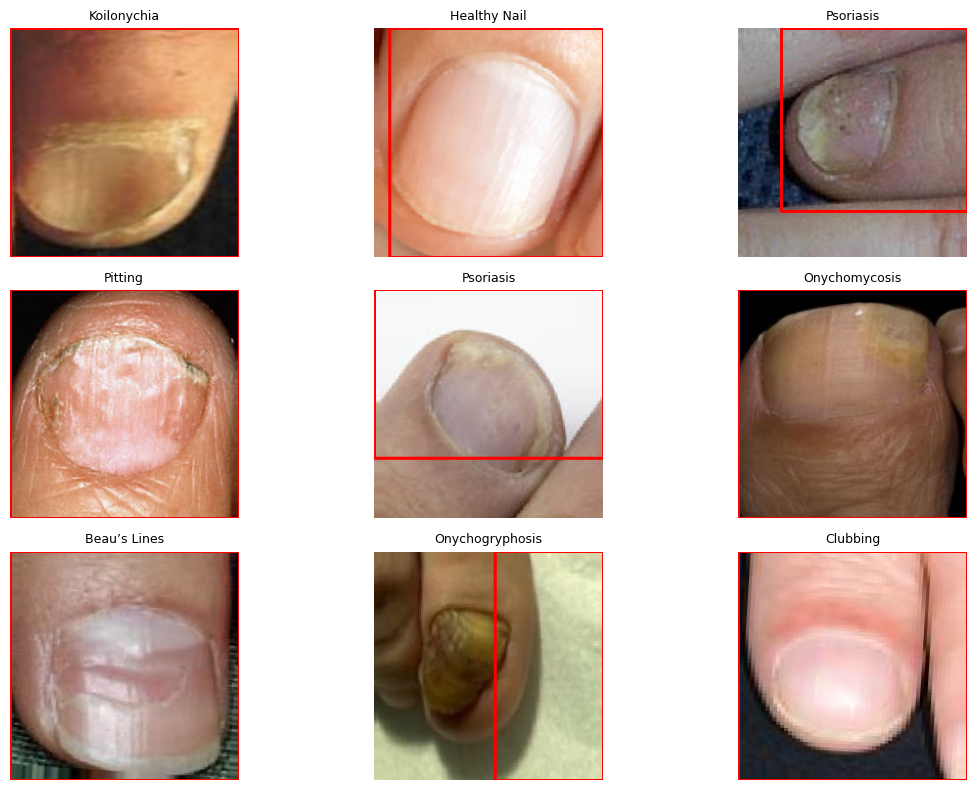

In [12]:
# 🟩 STEP 7: Visualize 9 full images with detected nail square
import matplotlib.pyplot as plt

images, labels = next(train_data)
plt.figure(figsize=(12, 8))

for i in range(9):
    img = (images[i]*255).astype(np.uint8).copy()  # restore 0-255 for cv2
    x1, y1, x2, y2 = detect_nail_bbox(img)

    # Draw rectangle around nail
    cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    img = img / 255.0  # back to 0-1 for plt

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    label_idx = np.argmax(labels[i])
    label_name = list(train_data.class_indices.keys())[label_idx]
    plt.title(label_name, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
# 🟩 STEP 8: Display class labels with numeric indices
for class_name, class_index in train_data.class_indices.items():
    print(f"{class_index} → {class_name}")

0 → Acral Lentiginous Melanoma
1 → Beau’s Lines
2 → Bluish Nail
3 → Clubbing
4 → Healthy Nail
5 → Koilonychia
6 → Onychogryphosis
7 → Onychomycosis
8 → Pitting
9 → Psoriasis
10 → White Nail (Leukonychia)
11 → Yellow Nail
